In [10]:
import Update_CDC
import pandas as pd

def US_tracker_update():
    """
    The purpose of this function is as follows:
    1. Import data from the CDC-TimeSeries table using the function above
    2. Presents the date, state, county, number of infections, and number of deaths
   
    """ 

    
    df = Update_CDC.mongodb_import('CDC-TimeSeries')

    df = df.loc[:,['Date','Country/Region' ,'Province/State', 'County/City', 'Confirmed','Death']].fillna(0)
    df['Confirmed'] = df['Confirmed'].astype(int)
    df['Death'] = df['Death'].astype(int)

    tracker = pd.DataFrame(columns=['num_infections', 'num_deaths'])

    tracker['num_infections'] = df.groupby(['Country/Region','Date','Province/State', 'County/City'])['Confirmed'].sum()   
    tracker['num_deaths'] = df.groupby(['Country/Region','Date','Province/State', 'County/City'])['Death'].sum()    
    
    tracker.reset_index(inplace= True)
    tracker.rename(columns={"Country/Region": "country",'Province/State': "state", 'County/City': "county", "Date": "date"}, inplace = True)
    US = tracker.loc[tracker.country == 'US']
    US = US.loc[US['county'] != ""]
    US = US.sort_values(by=['state', 'county', 'date']).reset_index(drop = True)
    US = US.drop(['country'], axis=1)
    
    # I realized the original dataset was in cumulative terms already --> had to un-cumulate
    US['num_infections'] = US.groupby(['state','county'])['num_infections'].diff().fillna(0)
    US['num_deaths'] = US.groupby(['state','county'])['num_deaths'].diff().fillna(0)

    return US


def US_cml_top10_tracker_update():

    """
    Cumulative tracker for cases and death for TOP 10 counties with the most number of cases on the most recent date from the collection
    The output also contains the column that tracks number of days since 150 cases were reached for that county
    
    """
    
    import pandas as pd
    from datetime import datetime
    US = US_tracker_update()

    threshold = 150
    
    
    US['state_county'] = US['state'] + "_" + US['county']            
    US['days_since_150_cases'] = ""         
    date_list = np.unique(US["date"].dt.strftime('%Y-%m-%d')).tolist()

    last_date = max(np.unique(US["date"].dt.strftime('%Y-%m-%d')).tolist())

    US["total_num_infections"] = US.groupby('county')['num_infections'].cumsum()
    US["total_num_deaths"] = US.groupby('county')['num_deaths'].cumsum()

    US_today = US.loc[(US.date == last_date)]
    US_today.sort_values(by = 'total_num_infections', ascending = False, inplace=True)
    top10 = US_today.head(10)

    county_list = top10.state_county.tolist()

    county_name = []
    over150 = []

    for county in county_list:
        for date in date_list:
            if US.loc[(US.date == date) & (US.state_county == county)].total_num_infections.values[0] > threshold:
                over150.append(date)
                county_name.append(county)
                break

    top10 = US.loc[(US.state_county == county_name[0])]
    for county in county_name[1:]:
        top10 = pd.concat([top10, US.loc[(US.state_county == county)]])


    over150 = [datetime.strptime(x, '%Y-%m-%d') for x in over150]
    for x in range(0,len(county_name)):
        for i in range(0,len(top10)):
            infection_date = over150[x]
            if top10.iloc[i,5] == county_name[x] and top10.iloc[i,0] == infection_date:
                top10.iloc[i,6] = 1
            elif top10.iloc[i,5] == county_name[x] and top10.iloc[i,0] >= infection_date:
                top10.iloc[i,6] = top10.iloc[i-1,6] + 1
            elif top10.iloc[i,5] == county_name[x] and top10.iloc[i,0] < infection_date:
                top10.iloc[i,6] = (top10.iloc[i,0] - over150[x]).days
    
    
    top10 = top10.drop(['num_infections','num_deaths', 'state_county'], axis=1)
    top10.reset_index(drop = True, inplace= True)
    return top10

In [30]:
top10 = US_cml_top10_tracker_update()
top10.head(80)

,date,state,county,days_since_150_cases,total_num_infections,total_num_deaths
0,2020-01-22,New York,New York,-51,0.0,0.0
1,2020-01-23,New York,New York,-50,0.0,0.0
2,2020-01-24,New York,New York,-49,0.0,0.0
3,2020-01-25,New York,New York,-48,0.0,0.0
4,2020-01-26,New York,New York,-47,0.0,0.0
...,...,...,...,...,...,...
75,2020-04-06,New York,New York,25,72181.0,3485.0
76,2020-04-07,New York,New York,26,76876.0,4009.0
77,2020-04-08,New York,New York,27,81803.0,4571.0
78,2020-04-09,New York,New York,28,87028.0,5150.0


In [20]:
county_list = top10.county.unique().tolist()
county_list

['New York', 'Suffolk', 'Nassau', 'Westchester', 'Cook', 'Middlesex', 'Essex']

In [33]:
top10['state_county'] = top10['county'] + ", " + top10['state'] 
county_list = top10.state_county.unique().tolist()
county_list
top10

,date,state,county,days_since_150_cases,total_num_infections,total_num_deaths,state_county
0,2020-01-22,New York,New York,-51,0.0,0.0,"New York, New York"
1,2020-01-23,New York,New York,-50,0.0,0.0,"New York, New York"
2,2020-01-24,New York,New York,-49,0.0,0.0,"New York, New York"
3,2020-01-25,New York,New York,-48,0.0,0.0,"New York, New York"
4,2020-01-26,New York,New York,-47,0.0,0.0,"New York, New York"
...,...,...,...,...,...,...,...
855,2020-04-12,Virginia,Essex,82,13342.0,782.0,"Essex, Virginia"
856,2020-04-13,Virginia,Essex,83,13342.0,782.0,"Essex, Virginia"
857,2020-04-14,Virginia,Essex,84,13342.0,782.0,"Essex, Virginia"
858,2020-04-15,Virginia,Essex,85,13342.0,782.0,"Essex, Virginia"


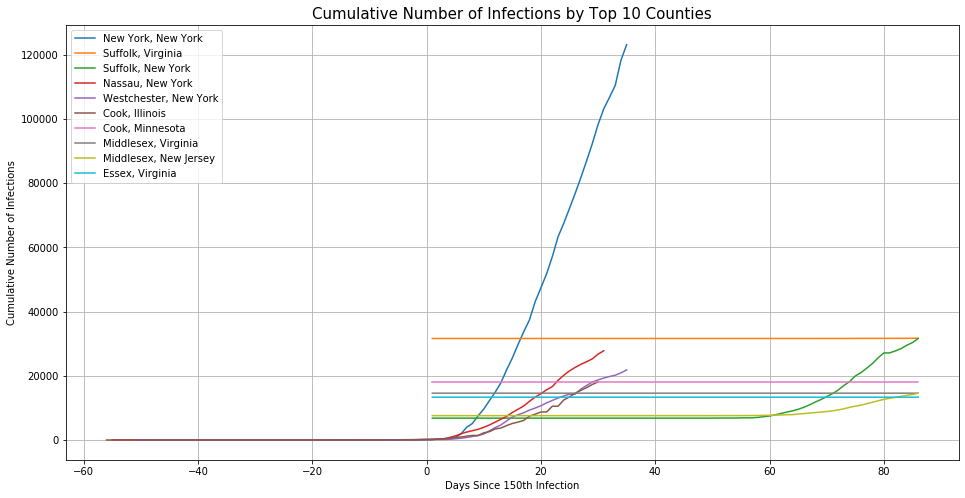

In [29]:
top10['state_county'] = top10['county'] + ", " + top10['state'] 
county_list = top10.state_county.unique().tolist()

plt.figure(figsize = (16,8))
for i in county_list:
    county = top10[top10.state_county == i]
    plt.plot("days_since_150_cases", "total_num_infections", data = county, label = i)
    plt.title("Cumulative Number of Infections by Top 10 Counties", size = 15)
    plt.xlabel("Days Since 150th Infection")
    plt.ylabel("Cumulative Number of Infections")
    plt.legend(loc=2)
plt.grid()
plt.show()

In [35]:
top10[top10.state_county == 'Cook, Minnesota']

,date,state,county,days_since_150_cases,total_num_infections,total_num_deaths,state_county
516,2020-01-22,Minnesota,Cook,1,18097.0,722.0,"Cook, Minnesota"
517,2020-01-23,Minnesota,Cook,2,18097.0,722.0,"Cook, Minnesota"
518,2020-01-24,Minnesota,Cook,3,18097.0,722.0,"Cook, Minnesota"
519,2020-01-25,Minnesota,Cook,4,18097.0,722.0,"Cook, Minnesota"
520,2020-01-26,Minnesota,Cook,5,18097.0,722.0,"Cook, Minnesota"
...,...,...,...,...,...,...,...
597,2020-04-12,Minnesota,Cook,82,18097.0,722.0,"Cook, Minnesota"
598,2020-04-13,Minnesota,Cook,83,18097.0,722.0,"Cook, Minnesota"
599,2020-04-14,Minnesota,Cook,84,18097.0,722.0,"Cook, Minnesota"
600,2020-04-15,Minnesota,Cook,85,18097.0,722.0,"Cook, Minnesota"


In [34]:
top10

,date,state,county,days_since_150_cases,total_num_infections,total_num_deaths,state_county
0,2020-01-22,New York,New York,-51,0.0,0.0,"New York, New York"
1,2020-01-23,New York,New York,-50,0.0,0.0,"New York, New York"
2,2020-01-24,New York,New York,-49,0.0,0.0,"New York, New York"
3,2020-01-25,New York,New York,-48,0.0,0.0,"New York, New York"
4,2020-01-26,New York,New York,-47,0.0,0.0,"New York, New York"
...,...,...,...,...,...,...,...
855,2020-04-12,Virginia,Essex,82,13342.0,782.0,"Essex, Virginia"
856,2020-04-13,Virginia,Essex,83,13342.0,782.0,"Essex, Virginia"
857,2020-04-14,Virginia,Essex,84,13342.0,782.0,"Essex, Virginia"
858,2020-04-15,Virginia,Essex,85,13342.0,782.0,"Essex, Virginia"
